In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
# Load synthetic dataset
df = pd.read_excel("../data/raw/synthetic_api_traffic.xlsx")
df.head()

,ID,TIMESTAMP,USER_ID,ENDPOINT,HTTP_METHOD,IP_ADDRESS,REQUEST_ID,USER_AGENT,USER_TIER,is_malicious,response_code,latency
0,59394c44-3096-4837-9869-606e2436c59e,2025-01-11 17:16:54.000000,3717,/browse,GET,12e4:1c76:85ce:52d5:2ef7:b3a:ad0e:e2d2,bd722974-3a9d-44b4-91d8-47d3b9c5d681,Mozilla/5.0 (Android 2.3.2; Mobile; rv:45.0) G...,STD,False,200,72
1,3541324f-01d7-4f7f-8a6c-bb1f1bcae9d4,2024-12-30 16:34:52.000000,4511,/browse,GET,0:0:0:0:0:0:0:1,c98abd76-2d79-4cc7-85da-319f2125219d,Opera/9.72.(X11; Linux x86_64; lb-LU) Presto/2...,PRM,False,200,179
2,e9fd22bd-ad17-4608-916f-4782039b10e4,2025-01-13 06:04:56.000000,1504,/browse,GET,73d8:e04d:68ef:d82c:4ff9:cdf3:a00d:2887,3a12fd17-4ae9-4da9-84fb-48e5f4e56ecc,Mozilla/5.0 (X11; Linux i686) AppleWebKit/531....,STD,False,200,177
3,45899cc7-8d71-485a-ac34-befaf7a7fd61,2025-01-13 04:17:47.000000,3550,/browse,GET,a4ed:e32f:4a35:700b:e7d:6baa:effc:81f3,0e43401a-0b3a-4223-8d50-b27bcc7011d9,Mozilla/5.0 (compatible; MSIE 8.0; Windows CE;...,STD,False,200,283
4,ec1645b8-1e22-48d0-8ce5-ccf11acffe73,2024-12-26 20:38:32.000000,3761,/browse,GET,679c:2c2:8c90:8bfd:1264:ff16:c562:e9db,1830cb6d-a156-4c72-bd33-d0ff70a5b3e5,Mozilla/5.0 (Android 1.5; Mobile; rv:53.0) Gec...,STD,False,200,164


In [4]:
# Convert timestamp and sort
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='ISO8601')
df = df.sort_values('TIMESTAMP').reset_index(drop=True)

In [5]:
# Hourly aggregation with enhanced features
hourly_traffic = df.groupby([
    pd.Grouper(key='TIMESTAMP', freq='1H'),
    'ENDPOINT'
]).agg(
    request_count=('ID', 'count'),
    premium_ratio=('USER_TIER', lambda x: (x == 'PRM').mean()),
    error_rate=('response_code', lambda x: (x >= 400).mean()),
    avg_latency=('latency', 'mean')
).reset_index()



C:\Users\new\AppData\Local\Temp\ipykernel_42704\1292956069.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(key='TIMESTAMP', freq='1H'),


In [6]:
# Pivot table
hourly_pivot = hourly_traffic.pivot(
    index='TIMESTAMP', 
    columns='ENDPOINT', 
    values=['request_count', 'premium_ratio', 'error_rate', 'avg_latency']
).fillna(0)
hourly_pivot.columns = [f"{col[0]}_{col[1].replace('/', '_')}" for col in hourly_pivot.columns]
hourly_pivot.head()

,request_count__browse,request_count__payment-gateway,request_count__test,premium_ratio__browse,premium_ratio__payment-gateway,premium_ratio__test,error_rate__browse,error_rate__payment-gateway,error_rate__test,avg_latency__browse,avg_latency__payment-gateway,avg_latency__test
TIMESTAMP,,,,,,,,,,,,
2024-12-26 12:00:00,6.0,2.0,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,216.500000,183.500000,0.000000
2024-12-26 13:00:00,40.0,16.0,7.0,0.300000,0.250000,0.285714,0.0,0.500000,0.0,166.275000,726.187500,125.571429
2024-12-26 14:00:00,55.0,18.0,7.0,0.218182,0.333333,0.285714,0.0,0.222222,0.0,168.054545,424.888889,127.000000
2024-12-26 15:00:00,43.0,23.0,5.0,0.279070,0.347826,0.400000,0.0,0.347826,0.0,175.837209,511.956522,196.800000
2024-12-26 16:00:00,55.0,12.0,11.0,0.327273,0.250000,0.272727,0.0,0.166667,0.0,178.236364,334.500000,167.272727


In [7]:
# IP-based features with enhanced metrics
ip_features = df.groupby('IP_ADDRESS').agg(
    request_freq=('ID', 'count'),
    payment_ratio=('ENDPOINT', lambda x: (x == '/payment-gateway').mean()),
    post_ratio=('HTTP_METHOD', lambda x: (x == 'POST').mean()),
    error_rate=('response_code', lambda x: (x >= 400).mean()),
    avg_latency=('latency', 'mean'),
    malicious_flag=('is_malicious', 'max')
).reset_index()

print("Anomaly detection features:")
ip_features.head()

Anomaly detection features:


,IP_ADDRESS,request_freq,payment_ratio,post_ratio,error_rate,avg_latency,malicious_flag
0,0:0:0:0:0:0:0:1,9977,0.192743,0.05673,0.0,174.651098,False
1,1.111.27.150,10,1.000000,1.00000,1.0,637.000000,True
2,1.176.191.108,10,1.000000,1.00000,1.0,1756.000000,True
3,1.236.147.222,10,1.000000,1.00000,1.0,969.000000,True
4,1.99.204.149,10,1.000000,1.00000,1.0,1039.000000,True


In [10]:
# Cell 6: Corrected Normalization Code (Final)
from sklearn.preprocessing import MinMaxScaler

# Step 1: Verify actual column names
print("Actual columns in hourly_pivot:", hourly_pivot.columns.tolist())

# Step 2: Adjust feature names to match
lstm_features = [
    'request_count__payment-gateway',  # Double underscore + hyphen
    'error_rate__payment-gateway',     # Double underscore + hyphen
    'avg_latency__payment-gateway'     # Double underscore + hyphen
]

# Step 3: Normalize
scaler = MinMaxScaler()
hourly_pivot[lstm_features] = scaler.fit_transform(hourly_pivot[lstm_features])
hourly_pivot.head()

Actual columns in hourly_pivot: ['request_count__browse', 'request_count__payment-gateway', 'request_count__test', 'premium_ratio__browse', 'premium_ratio__payment-gateway', 'premium_ratio__test', 'error_rate__browse', 'error_rate__payment-gateway', 'error_rate__test', 'avg_latency__browse', 'avg_latency__payment-gateway', 'avg_latency__test']


,request_count__browse,request_count__payment-gateway,request_count__test,premium_ratio__browse,premium_ratio__payment-gateway,premium_ratio__test,error_rate__browse,error_rate__payment-gateway,error_rate__test,avg_latency__browse,avg_latency__payment-gateway,avg_latency__test
TIMESTAMP,,,,,,,,,,,,
2024-12-26 12:00:00,6.0,0.028571,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,216.500000,0.018357,0.000000
2024-12-26 13:00:00,40.0,0.428571,7.0,0.300000,0.250000,0.285714,0.0,0.500000,0.0,166.275000,0.356059,125.571429
2024-12-26 14:00:00,55.0,0.485714,7.0,0.218182,0.333333,0.285714,0.0,0.222222,0.0,168.054545,0.168568,127.000000
2024-12-26 15:00:00,43.0,0.628571,5.0,0.279070,0.347826,0.400000,0.0,0.347826,0.0,175.837209,0.222748,196.800000
2024-12-26 16:00:00,55.0,0.314286,11.0,0.327273,0.250000,0.272727,0.0,0.166667,0.0,178.236364,0.112321,167.272727


In [11]:
def create_sequences(data, window_size=24, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data)-window_size-forecast_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon, 0])  # Predict request count
    return np.array(X), np.array(y)

X, y = create_sequences(hourly_pivot[lstm_features].values)
print(f"Sequences created - X: {X.shape}, y: {y.shape}")

Sequences created - X: (707, 24, 3), y: (707, 1)


In [12]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (565, 24, 3), Test: (142, 24, 3)


In [13]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(loss='mae', optimizer='adam')
model.summary()

d:\api_rate_limiter\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2340 - val_loss: 0.1713
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1157 - val_loss: 0.1487
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1067 - val_loss: 0.1472
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1064 - val_loss: 0.1488
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0979 - val_loss: 0.1460
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1054 - val_loss: 0.1499
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1036 - val_loss: 0.1459
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1026 - val_loss: 0.1453
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1018 - val_loss: 0.1452
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1009 - val_loss: 0.1454
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1060 - val_loss: 0.1468
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1095 - val_l

In [15]:
# Normalize features
anomaly_scaler = MinMaxScaler()
anomaly_features = anomaly_scaler.fit_transform(
    ip_features[['request_freq', 'payment_ratio', 'post_ratio', 'error_rate', 'avg_latency']]
)

In [16]:
malicious_ratio = ip_features['malicious_flag'].mean()
anomaly_model = IsolationForest(
    contamination=malicious_ratio,
    n_estimators=200,
    random_state=42
)
anomaly_model.fit(anomaly_features)
print(f"Trained anomaly detector on {malicious_ratio:.1%} contamination")

Trained anomaly detector on 1.3% contamination


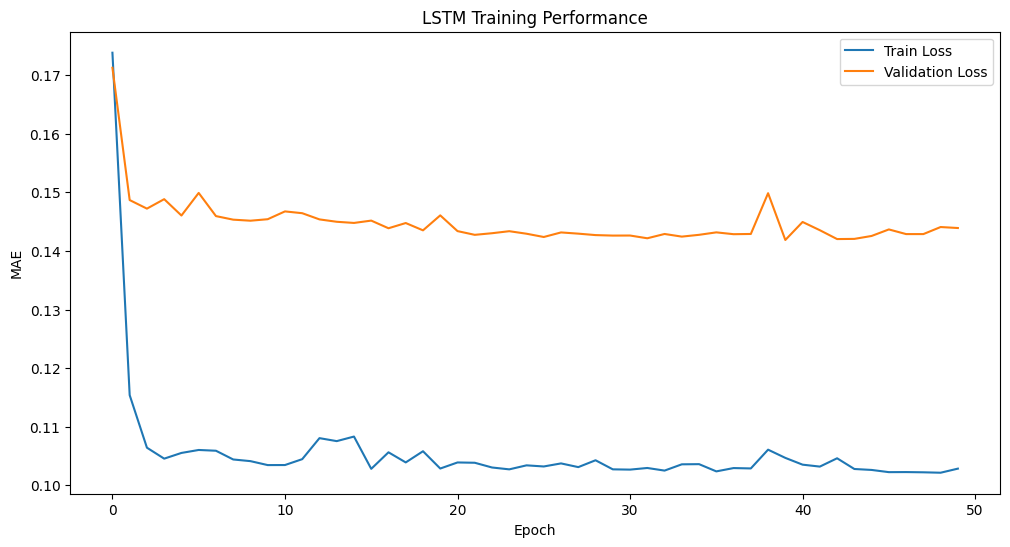

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Performance')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

Precision: 100.00%
Recall: 100.00%


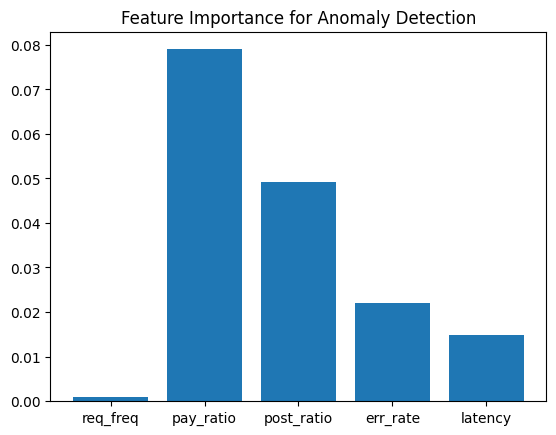

In [18]:
# Calculate metrics
ip_features['anomaly_score'] = anomaly_model.decision_function(anomaly_features)
ip_features['predicted_anomaly'] = anomaly_model.predict(anomaly_features)

true_positives = ip_features[(ip_features['predicted_anomaly'] == -1) & 
                            (ip_features['malicious_flag'] == 1)].shape[0]
total_predicted = ip_features[ip_features['predicted_anomaly'] == -1].shape[0]

print(f"Precision: {true_positives/total_predicted:.2%}")
print(f"Recall: {true_positives/ip_features['malicious_flag'].sum():.2%}")

# Feature importance
feature_importance = np.std(anomaly_features, axis=0) * np.abs(ip_features['anomaly_score'].mean())
plt.bar(['req_freq', 'pay_ratio', 'post_ratio', 'err_rate', 'latency'], feature_importance)
plt.title('Feature Importance for Anomaly Detection')
plt.show()

In [19]:
model.save("../models/lstm_payment_traffic_predictor.h5")

import joblib
joblib.dump(anomaly_model, "../models/payment_anomaly_detector.pkl")
joblib.dump(scaler, "../models/lstm_scaler.pkl")
joblib.dump(anomaly_scaler, "../models/anomaly_scaler.pkl")

print("All models saved!")

All models saved!


In [20]:
import sys
sys.path.append("../src")  # Add src/ to Python path

from adaptive_limiter import AdaptiveRateLimiter

# Initialize rate limiter with config
limiter = AdaptiveRateLimiter(config_path="../src/config/rate_limits.json")

# Example usage:
predicted_traffic = 2500  # From LSTM model
anomaly_ips = ["192.168.1.1", "10.0.0.5"]  # From Isolation Forest

adjusted_limits = limiter.adjust_limits(predicted_traffic, anomaly_ips)
print("Adjusted Rate Limits:", adjusted_limits)

Adjusted Rate Limits: {'STD': {'/payment-gateway': 50, '/browse': 250}, 'PRM': {'/payment-gateway': 500, '/browse': 1000}, 'anomalies': {'192.168.1.1': {'/payment-gateway': 10, '/browse': 50}, '10.0.0.5': {'/payment-gateway': 10, '/browse': 50}}}
